In [1]:
# fmt: off
import cirq
import stim
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt

from bloqade import squin
from bloqade.squin import kernel
from bloqade.tsim import Circuit
import bloqade.cirq_utils as utils
from cirq.contrib.svg import SVGCircuit
import numpy as np

In [ ]:
def make_steane_encoding_kernel(n_iterations: int, basis: str, inject_magic: bool):
    """
    Build a simplified 7-qubit Steane encoding kernel.
    """

    @kernel
    def encode_block(q_block):
        """Encode a single 7-qubit block using simplified Steane gates."""
        # Initial sqrt(Y) rotation on first 6 qubits
        squin.broadcast.sqrt_y_adj(q_block[:6])

        # CZ gates between pairs for entanglement
        squin.broadcast.cz([q_block[1], q_block[3], q_block[5]], [q_block[2], q_block[4], q_block[6]])

        # Local rotations and more CZ gates
        squin.broadcast.sqrt_y([q_block[6]])
        squin.broadcast.cz([q_block[0], q_block[2], q_block[4]], [q_block[3], q_block[5], q_block[6]])
        squin.broadcast.sqrt_y(q_block[2:])
        squin.broadcast.cz([q_block[0], q_block[2], q_block[4]], [q_block[1], q_block[3], q_block[5]])
        squin.broadcast.sqrt_y([q_block[1], q_block[2], q_block[4]])

    @kernel
    def measure_subset(qubits):
        """Measure selected qubits in the chosen basis."""
        if basis == 'X':
            squin.broadcast.h([qubits[0], qubits[1], qubits[5]])
        elif basis == 'Y':
            squin.broadcast.s_adj([qubits[0], qubits[1], qubits[5]])
            squin.broadcast.h([qubits[0], qubits[1], qubits[5]])

        squin.broadcast.measure([qubits[0], qubits[1], qubits[5]])

    @kernel
    def measure_all(qubits):
        """Measure all qubits in computational basis."""
        squin.broadcast.measure(qubits)

    @kernel
    def circuit():
        # Allocate qubits for logical, plus, and zero blocks
        q_logical = squin.qalloc(7)
        q_plus = squin.qalloc(7)
        q_zero = squin.qalloc(7)

        # Inject magic state if requested
        if inject_magic:
            squin.broadcast.h(q_logical[-1])
            squin.broadcast.t_adj(q_logical[-1])

        # Prepare auxiliary + state
        for _ in range(n_iterations):
            squin.broadcast.h(q_plus[-1])
            encode_block(q_logical)
            encode_block(q_plus)
            encode_block(q_zero)

            # Entangle logical, plus, and zero blocks
            squin.broadcast.cx(q_logical, q_plus)
            squin.broadcast.cx(q_zero, q_logical)

        # Measure blocks
        measure_all(q_plus)
        squin.broadcast.h(q_zero)
        measure_all(q_zero)

        # Classical logic involving if statements
        # <===== Here ======>

        measure_subset(q_logical)

    return circuit


# Example usage
steane_kernel = make_steane_encoding_kernel(n_iterations=1, basis='Z', inject_magic=False)
c = Circuit(steane_kernel)
c.diagram(height=540)


In [15]:
def embed_mover_noise(k, noise_param, dnoise):
    """
    Apply Gemini noise to a Squin kernel.
    """
    # Convert Squin kernel to Cirq circuit
    cirq_circuit = utils.emit_circuit(k)

    # Set default noise for each parameter
    default_noises = {param: dnoise for param in noise_param}

    # Initialize Gemini noise model
    noise_model = utils.noise.GeminiOneZoneNoiseModel(**default_noises)

    # Apply noise and convert to native gates, parallelizing if possible
    noisy_cirq_circuit = utils.noise.transform_circuit(
        cirq_circuit, to_native_gateset=True, model=noise_model, parallelize_circuit=True
    )

    # Load back into Squin
    squin_circuit = utils.load_circuit(noisy_cirq_circuit, kernel_name="main_loaded")

    return squin_circuit


In [16]:
def eigen_calc(arr):
    eigenvalues = np.where(arr == 0, 1, -1)   
    return eigenvalues 

def eigen_calc_prod(arr):
    eigenvalues = eigen_calc(arr)
    logical_eigen = np.prod(eigenvalues, axis=1) 
    logical_bit = np.where(logical_eigen == 1, 0, 1)

    return logical_bit

In [17]:
def get_bit_and_stabilizers(kernel):
    """
    Run the kernel and extract logical measurement outcomes and stabilizers.
    """
    # Sample measurement outcomes
    samples = kernel.compile_sampler(seed=0).sample(shots=5000, batch_size=10000)

    # Split samples into logical qubits, plus block, and zero block
    logical_combination = samples[:, :3]
    plus_syndromes = samples[:, 3:10]
    zero_syndromes = samples[:, 10:17]

    # Compute logical bit values
    logical_bit = eigen_calc_prod(logical_combination)

    # Compute X-type stabilizers from + block
    plus_stabilizers = np.stack([
        eigen_calc_prod(plus_syndromes[:, [0, 1, 2, 3]]),
        eigen_calc_prod(plus_syndromes[:, [1, 2, 4, 5]]),
        eigen_calc_prod(plus_syndromes[:, [2, 4, 6, 3]])
    ], axis=1)

    # Compute Z-type stabilizers from 0 block
    zero_stabilizers = np.stack([
        eigen_calc_prod(zero_syndromes[:, [0, 1, 2, 3]]),
        eigen_calc_prod(zero_syndromes[:, [1, 2, 4, 5]]),
        eigen_calc_prod(zero_syndromes[:, [2, 4, 6, 3]])
    ], axis=1)

    # Combine X and Z stabilizers
    stabilizers = np.concatenate([plus_stabilizers, zero_stabilizers], axis=1)

    return logical_bit, stabilizers


def build_and_run(basis, noise_params, dnoise, magic=False):
    """
    Build a noisy Steane encoding circuit, run it, and return expectation
    and fraction of postselected shots.
    """
    # Build the kernel
    steane_kernel = make_steane_encoding_kernel(
        n_iterations=1,
        basis=basis,
        inject_magic=magic
    )

    # Apply noise
    noisy_kernel = embed_mover_noise(steane_kernel, noise_params, dnoise)
    c_noise = Circuit(noisy_kernel)

    # Extract logical bits and stabilizers
    logical_bit, stabilizers = get_bit_and_stabilizers(c_noise)

    # Postselect on trivial syndrome
    postselect_mask = np.all(stabilizers == np.array([0, 0, 0, 1, 0, 0]), axis=1)
    logical_bit = logical_bit[postselect_mask]

    # Compute expectation value of logical Pauli
    p1 = np.count_nonzero(logical_bit) / len(logical_bit)
    expectation = 1 - 2 * p1

    return expectation, p1


def get_fidelity(psi, noise_params, dnoise, magic=False):
    """
    Compute fidelity of a logical state |psi> under noise.
    Returns fidelity and postselection probability.
    """
    # Logical Pauli expectation values
    vx, _ = build_and_run('X', noise_params, dnoise, magic)
    vy, _ = build_and_run('Y', noise_params, dnoise, magic)
    vz, p = build_and_run('Z', noise_params, dnoise, magic)

    # Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    # Reconstruct logical density matrix
    rho = (I + vx * X + vy * Y + vz * Z) / 2

    # Fidelity ⟨psi|rho|psi⟩
    fidelity = psi.conj().T @ rho @ psi

    return fidelity.real, p


In [18]:
def sweep_fidelities(psi, noise_params, noises, magic=False):
    fidelities = []
    for dnoise in noises:
        fidelities.append(get_fidelity(psi, noise_params, dnoise, magic)[0])
    
    return fidelities

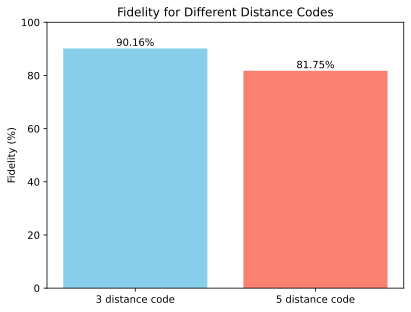

In [19]:
# Data
labels = ['3 distance code', '5 distance code']
fidelities = [90.16, 81.75] # Values were obtained previously in the notebook, can get via get_fidelity method

# Sort bars by fidelity descending
sorted_indices = sorted(range(len(fidelities)), key=lambda k: fidelities[k], reverse=True)
labels = [labels[i] for i in sorted_indices]
fidelities = [fidelities[i] for i in sorted_indices]

# Plotting
plt.bar(labels, fidelities, color=['skyblue', 'salmon'])

# Adding details
plt.ylabel('Fidelity (%)')
plt.title('Fidelity for Different Distance Codes')
plt.ylim(0, 100)

# Adding text labels on top of bars
for i, v in enumerate(fidelities):
    plt.text(i, v + 1, f"{v}%", ha='center')

# Save the plot
plt.savefig('fidelity_bar_plot.png')

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fidelity(parameters, names):
    noises = np.linspace(0, 0.25, 15)
    
    for i, param_set in enumerate(parameters):
        plt.figure(figsize=(8, 6))
        
        # Non-magic state |0>
        psi_zero = np.array([1, 0])
        fidelities_no_magic = sweep_fidelities(psi_zero, param_set, noises, magic=False)
        plt.plot(noises, [1 - fid for fid in fidelities_no_magic], label="No Magic", linestyle='-', marker='o')
        
        # Magic T state
        psi_T = np.array([1, np.exp(1j * np.pi / 4)]) / np.sqrt(2)
        fidelities_magic = sweep_fidelities(psi_T, param_set, noises, magic=True)
        plt.plot(noises, [1 - fid for fid in fidelities_magic], label="Magic T State", linestyle='--', marker='s')
        
        
        plt.ylabel("Logical Error Rate")
        plt.xlabel("Physical Noise Rate")
        plt.title(f"Noise Effects on Fidelity: {names[i]}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


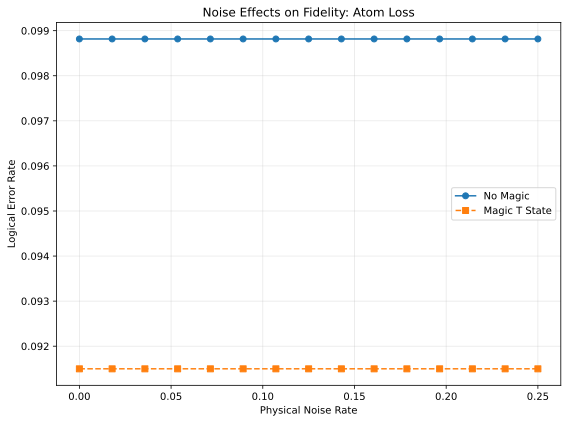

/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


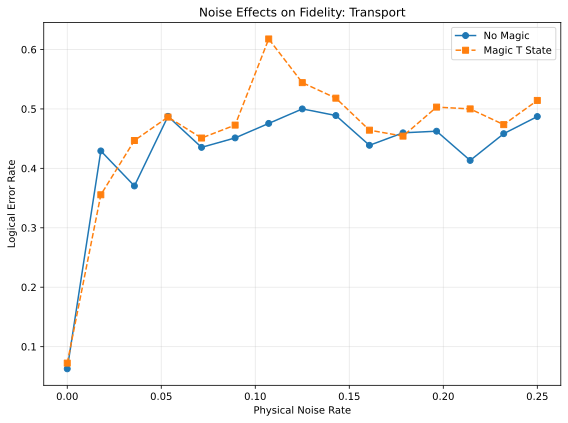

/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


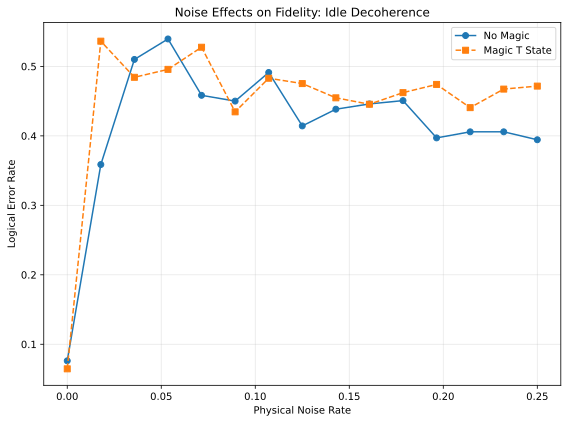

/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


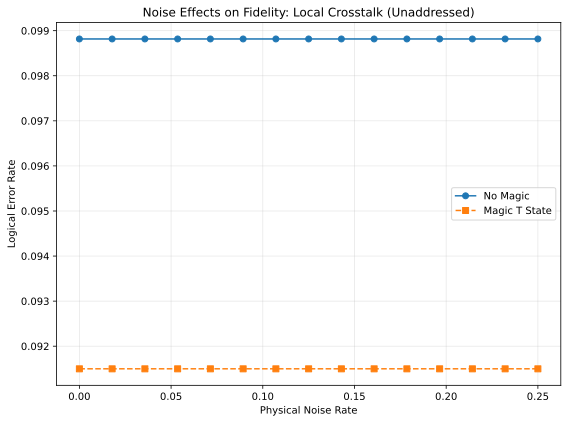

/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


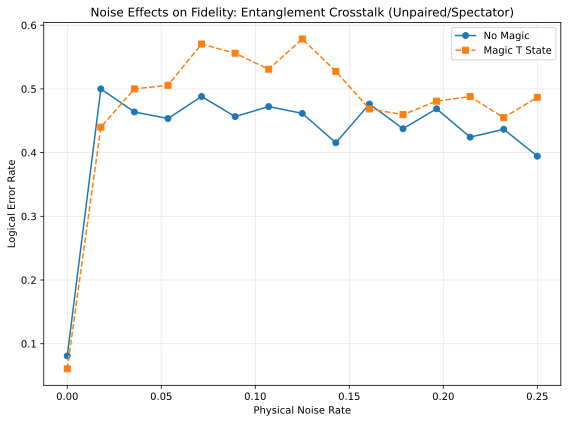

/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


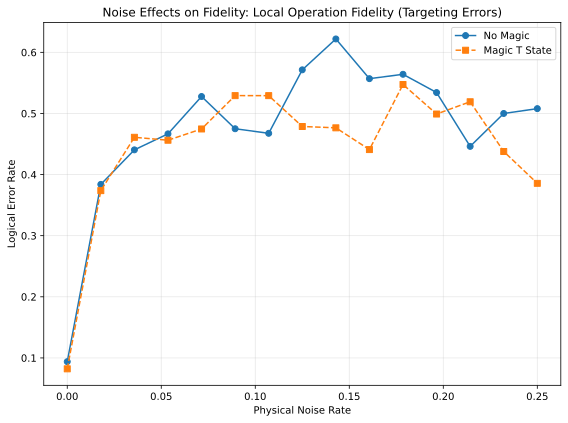

/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dhruvachayapathy/Projects/2026-QuEra-Technical-PhaZeClan/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


: 

: 

In [19]:
plot_fidelity(
    [
        # Atom Loss
        [
            "local_loss_prob",
            "global_loss_prob",
            "cz_gate_loss_prob",
            "cz_unpaired_loss_prob",
            "move_loss_prob",
            "sit_loss_prob",
            "local_unaddressed_loss_prob",
        ],

        # Transport
        [
            "mover_px",
            "mover_py",
            "mover_pz",
        ],

        # Idle Decoherence
        [
            "sitter_px",
            "sitter_py",
            "sitter_pz",
        ],

        # Local Crosstalk (Unaddressed)
        [
            "local_unaddressed_px",
            "local_unaddressed_py",
            "local_unaddressed_pz",
        ],

        # Entanglement Crosstalk (Unpaired / Spectator)
        [
            "cz_unpaired_gate_px",
            "cz_unpaired_gate_py",
            "cz_unpaired_gate_pz",
        ],

        # Local Operation Fidelity (Targeting Errors)
        [
            "local_px",
            "local_py",
            "local_pz",
        ],

        # Global Operation Fidelity (Broadcast)
        [
            "global_px",
            "global_py",
            "global_pz",
        ],

        # Native Entanglement Fidelity (Paired CZ)
        [
            "cz_paired_gate_px",
            "cz_paired_gate_py",
            "cz_paired_gate_pz",
        ],
    ],
    [
        "Atom Loss",
        "Transport",
        "Idle Decoherence",
        "Local Crosstalk (Unaddressed)",
        "Entanglement Crosstalk (Unpaired/Spectator)",
        "Local Operation Fidelity (Targeting Errors)",
        "Global Operation Fidelity (Broadcast)",
        "Native Entanglement Fidelity (Paired CZ)",
    ]
)


In [ ]:
squin.measure